# Preparing input from adata to cellphone input

Creating the database and subsetting interactions happened in the validation cohort analysis folders (see notebooks S0 and S1)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import anndata
# requires 'pip install scrublet'
#import scrublet as scr
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
%%bash

pip freeze

aiohttp==3.7.3
airr==1.3.1
alabaster==0.7.12
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1611176215154/work
aniso8601==9.0.1
anndata @ file:///home/conda/feedstock_root/build_artifacts/anndata_1605539061264/work
annoy @ file:///home/conda/feedstock_root/build_artifacts/python-annoy_1610271511811/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1610315727443/work/dist
arboreto==0.1.6
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1610522574055/work
async-generator==1.10
async-timeout==3.0.1
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1605083924122/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1605182336601/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
bbknn @ file:///opt/conda/conda-bld/bbknn_1610991770283/work
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_1611678357911

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.4
chardet             3.0.4
cloudpickle         1.6.0
colorama            0.4.4
constants           NA
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.02.0
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                2.10.0
highs_wrapper       NA
idna                2.10
igraph              0.8.3
ipykernel           5.4.2
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.17.2
jinja2              2.11.2
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.2.2
jupyterlab_server   2.1.3
kiwisolver          1.3.1
le

In [5]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/202102_twins_reanalysis/'

## Reding the fully analysed object


In [6]:
# reading the fully analysed object, final annotation in 'cell_type_final', normalised, log tr and scaled in .X (HVG-subsetted)
# norm, log tr in .raw.X, all genes
adata_hvg = sc.read(save_path+'adata_hvg_bbknn_by_sample_nodoublets_20_PCs_final_manifold_with_annotation_after_celanup.h5ad')

In [7]:
adata_hvg

AnnData object with n_obs × n_vars = 16901 × 2428
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'probabilities', 'celltype_predictions', 'cell_type', 'S_score', 'G2M_score', 'phase', 'cell_type_corrected', 'cell_type_corrected_final'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'activation_colors', 'ccgs', 'cell_type_colors', 'cell_type_corrected_colors', 'cell_type_corrected_final_colors', 'celltype_predictions_colors', 'condition_colors', 'hvg', 'n

In [8]:
len(adata_hvg.raw.var_names)

17976

In [9]:
for gene in adata_hvg.raw.var_names:
    if 'IL12' in gene:
        print(gene)

IL12RB2
IL12A
IL12RB1


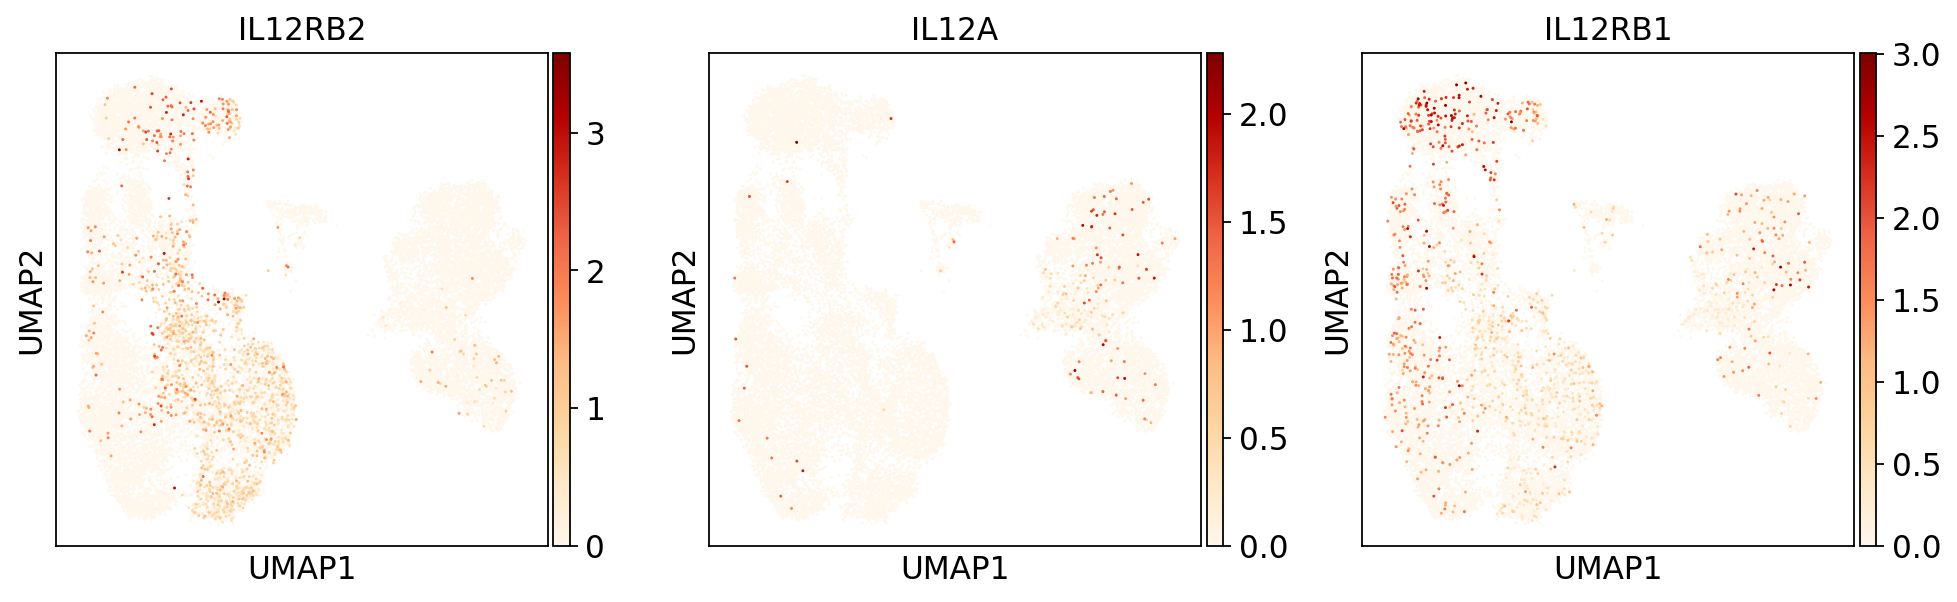

In [10]:
sc.pl.umap(adata_hvg, color=['IL12RB2', 'IL12A', 'IL12RB1'], cmap='OrRd',
          use_raw=True)

In [10]:
# reading the raw count data
adata_raw = sc.read(save_path+'adata_raw_filtered.h5ad')

In [11]:
# subsetting to only final cells
adata_raw = adata_raw[adata_hvg.obs_names,:].copy()

In [12]:
adata_raw.obs['cell_type'] = adata_hvg.obs.loc[adata_raw.obs_names,'cell_type_corrected_final']

In [13]:
# genes have been filtered during preprocessing
adata_raw

AnnData object with n_obs × n_vars = 16901 × 17976
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'cell_type'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5'

In [14]:
adata_raw.obs['cell_type'].value_counts()

T4_activated                2927
B_cells_memory_activated    2376
T4_memory                   1772
B_cells_naive               1262
NK_CD16_bright_activated    1235
B_cells_naive_activated      944
T8_activated_1               830
NK_CD16_bright               763
T_gd                         697
T4_naive                     675
T8_memory                    558
T8_naive                     408
T_regs                       388
B_cells_memory               347
MAIT_cells                   299
T8_activated_2               288
Myeloid_cells                285
NK_CD56_bright               238
MAIT_cells_activated         219
NK_CD56_bright_activated     200
B_cells_oligoclonal          190
Name: cell_type, dtype: int64

In [15]:
# normalising raw counts
sc.pp.normalize_per_cell(adata_raw, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [16]:
# normalised count values
adata_count = anndata.AnnData(X=adata_raw.X, var=adata_raw.var, obs=adata_raw.obs)
t = adata_count.X.toarray().T
# Set cell ids as column index and gene ids as row index
df_expr_matrix = pd.DataFrame(data=t, columns= adata_count.obs.index, index=adata_count.var_names)

In [17]:
df_expr_matrix

index,TCAGGATCAGTTTACG-1,GATCGCGTCCTACAGA-1,CGATCGGCACGGCCAT-1,CATGACACAACCGCCA-1,GACAGAGAGTGTTTGC-1,GCGAGAAGTACTCAAC-1,GAATGAAGTTCACGGC-1,CACTCCATCCAAGCCG-1,GCGCAGTTCACTCCTG-1,CTCCTAGCATCATCCC-1,...,CAGCGACGTTACTGAC-1,CGGAGTCAGAACTGTA-1,AGCAGCCTCTTAACCT-1,CATCCACGTTGTGGCC-1,CTGTGCTGTAAGTTCC-1,GTCTTCGGTCTACCTC-1,GTTAAGCAGCGTAGTG-1,TAAGCGTTCTAGAGTC-1,TATTACCTCACCCGAG-1,CCTTCCCCAACTGCTA-1
index,,,,,,,,,,,,,,,,,,,,,
RP11-34P13.7,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
FO538757.3,0.0,0.0,0.0,2.909514,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
FO538757.2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.037775,0.0,0.0
AP006222.2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
RP5-857K21.4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RP4-681N20.5,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
LINC00659,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
PON3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [18]:
df_meta = pd.DataFrame(data={'Cell':list(adata_count.obs.index),
                             'cell_type':[ 'celltype_'+str(i) for i in adata_count.obs['cell_type']] })
df_meta.set_index('Cell', inplace=True)
df_meta

,cell_type
Cell,
TCAGGATCAGTTTACG-1,celltype_B_cells_memory_activated
GATCGCGTCCTACAGA-1,celltype_B_cells_naive
CGATCGGCACGGCCAT-1,celltype_B_cells_naive
CATGACACAACCGCCA-1,celltype_B_cells_naive
GACAGAGAGTGTTTGC-1,celltype_B_cells_naive_activated
...,...
GTCTTCGGTCTACCTC-1,celltype_T4_activated
GTTAAGCAGCGTAGTG-1,celltype_T4_memory
TAAGCGTTCTAGAGTC-1,celltype_T4_activated


In [19]:
%%time

# started at 12:50 18.02.2021
# takes a few minutes
# saving for cellphonedb

savepath_meta = save_path + '20210322_cellphonedb_meta.tsv'
df_meta.to_csv(savepath_meta, sep = '\t')

print('saved metadata, saving counts now')

savepath_counts = save_path + '20210322_cellphonedb_counts.csv'
df_expr_matrix.to_csv(savepath_counts)

saved metadata, saving counts now
CPU times: user 3min 44s, sys: 3.71 s, total: 3min 47s
Wall time: 4min 2s


In [20]:
np.unique(df_meta['cell_type'], return_counts=True)

(array(['celltype_B_cells_memory', 'celltype_B_cells_memory_activated',
        'celltype_B_cells_naive', 'celltype_B_cells_naive_activated',
        'celltype_B_cells_oligoclonal', 'celltype_MAIT_cells',
        'celltype_MAIT_cells_activated', 'celltype_Myeloid_cells',
        'celltype_NK_CD16_bright', 'celltype_NK_CD16_bright_activated',
        'celltype_NK_CD56_bright', 'celltype_NK_CD56_bright_activated',
        'celltype_T4_activated', 'celltype_T4_memory', 'celltype_T4_naive',
        'celltype_T8_activated_1', 'celltype_T8_activated_2',
        'celltype_T8_memory', 'celltype_T8_naive', 'celltype_T_gd',
        'celltype_T_regs'], dtype=object),
 array([ 347, 2376, 1262,  944,  190,  299,  219,  285,  763, 1235,  238,
         200, 2927, 1772,  675,  830,  288,  558,  408,  697,  388]))

In [20]:
save_path


'/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/202102_twins_reanalysis/'

In [21]:
df_expr_matrix

index,TCAGGATCAGTTTACG-1,GATCGCGTCCTACAGA-1,CGATCGGCACGGCCAT-1,CATGACACAACCGCCA-1,GACAGAGAGTGTTTGC-1,GCGAGAAGTACTCAAC-1,GAATGAAGTTCACGGC-1,CACTCCATCCAAGCCG-1,GCGCAGTTCACTCCTG-1,CTCCTAGCATCATCCC-1,...,CAGCGACGTTACTGAC-1,CGGAGTCAGAACTGTA-1,AGCAGCCTCTTAACCT-1,CATCCACGTTGTGGCC-1,CTGTGCTGTAAGTTCC-1,GTCTTCGGTCTACCTC-1,GTTAAGCAGCGTAGTG-1,TAAGCGTTCTAGAGTC-1,TATTACCTCACCCGAG-1,CCTTCCCCAACTGCTA-1
index,,,,,,,,,,,,,,,,,,,,,
RP11-34P13.7,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
FO538757.3,0.0,0.0,0.0,2.909514,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
FO538757.2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.037775,0.0,0.0
AP006222.2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
RP5-857K21.4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RP4-681N20.5,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
LINC00659,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
PON3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [22]:
for gene in list(df_expr_matrix.index):
    if 'IL12' in gene:
        print(gene)

IL12RB2
IL12A
IL12RB1


In [23]:
'IL12A' in list(df_expr_matrix.index)

True

In [24]:
'IL12AR' in list(df_expr_matrix.index)

False

# Preparing a table of expression proportions

Matrix of genes (rows) per celltypes (columns) containing the proportion [0-1] of cells in a celltype expressing the gene

In [26]:
np.unique(adata_hvg.obs['cell_type_corrected_final'], return_counts=True)

(array(['B_cells_memory', 'B_cells_memory_activated', 'B_cells_naive',
        'B_cells_naive_activated', 'B_cells_oligoclonal', 'MAIT_cells',
        'MAIT_cells_activated', 'Myeloid_cells', 'NK_CD16_bright',
        'NK_CD16_bright_activated', 'NK_CD56_bright',
        'NK_CD56_bright_activated', 'T4_activated', 'T4_memory',
        'T4_naive', 'T8_activated_1', 'T8_activated_2', 'T8_memory',
        'T8_naive', 'T_gd', 'T_regs'], dtype=object),
 array([ 347, 2376, 1262,  944,  190,  299,  219,  285,  763, 1235,  238,
         200, 2927, 1772,  675,  830,  288,  558,  408,  697,  388]))

In [27]:
df_expr_matrix_per_cell_type = {}

for ct in np.unique(adata_hvg.obs['cell_type_corrected_final']):
    print(ct)
    curr_subset_of_barcodes = list(adata_hvg[adata_hvg.obs['cell_type_corrected_final'] == ct].obs_names)
    df_expr_matrix_per_cell_type[ct] = df_expr_matrix.loc[:,curr_subset_of_barcodes]
    print(len(curr_subset_of_barcodes), 'cells of this cell type')
    print('subsetted a table of shape', df_expr_matrix_per_cell_type[ct].shape, '\n')

B_cells_memory
347 cells of this cell type
subsetted a table of shape (17976, 347) 

B_cells_memory_activated
2376 cells of this cell type
subsetted a table of shape (17976, 2376) 

B_cells_naive
1262 cells of this cell type
subsetted a table of shape (17976, 1262) 

B_cells_naive_activated


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


944 cells of this cell type
subsetted a table of shape (17976, 944) 

B_cells_oligoclonal
190 cells of this cell type
subsetted a table of shape (17976, 190) 

MAIT_cells
299 cells of this cell type
subsetted a table of shape (17976, 299) 

MAIT_cells_activated
219 cells of this cell type
subsetted a table of shape (17976, 219) 

Myeloid_cells
285 cells of this cell type
subsetted a table of shape (17976, 285) 

NK_CD16_bright
763 cells of this cell type
subsetted a table of shape (17976, 763) 

NK_CD16_bright_activated
1235 cells of this cell type
subsetted a table of shape (17976, 1235) 

NK_CD56_bright
238 cells of this cell type
subsetted a table of shape (17976, 238) 

NK_CD56_bright_activated
200 cells of this cell type
subsetted a table of shape (17976, 200) 

T4_activated
2927 cells of this cell type
subsetted a table of shape (17976, 2927) 

T4_memory
1772 cells of this cell type
subsetted a table of shape (17976, 1772) 

T4_naive
675 cells of this cell type
subsetted a table 

In [28]:
# how many non-zero elements does this row vector contain? in proportion
df_expr_matrix_per_cell_type['T_regs'].astype(bool).sum(axis=1)/df_expr_matrix_per_cell_type['T_regs'].shape[1]

index
RP11-34P13.7    0.000000
FO538757.3      0.002577
FO538757.2      0.087629
AP006222.2      0.028351
RP5-857K21.4    0.007732
                  ...   
RP4-681N20.5    0.000000
LINC00659       0.002577
PON3            0.000000
USP43           0.000000
RP11-394J1.2    0.000000
Length: 17976, dtype: float64

In [29]:
df_percentage_expressed = pd.DataFrame(index = df_expr_matrix.index,
                                      columns=np.unique(adata_hvg.obs['cell_type_corrected_final']))

In [30]:
for col in df_percentage_expressed.columns:
    print(col)
    df_percentage_expressed.loc[:,col] = df_expr_matrix_per_cell_type[col].astype(bool).sum(axis=1)/df_expr_matrix_per_cell_type[col].shape[1]

B_cells_memory
B_cells_memory_activated
B_cells_naive
B_cells_naive_activated
B_cells_oligoclonal
MAIT_cells
MAIT_cells_activated
Myeloid_cells
NK_CD16_bright
NK_CD16_bright_activated
NK_CD56_bright
NK_CD56_bright_activated
T4_activated
T4_memory
T4_naive
T8_activated_1
T8_activated_2
T8_memory
T8_naive
T_gd
T_regs


In [31]:
df_percentage_expressed

,B_cells_memory,B_cells_memory_activated,B_cells_naive,B_cells_naive_activated,B_cells_oligoclonal,MAIT_cells,MAIT_cells_activated,Myeloid_cells,NK_CD16_bright,NK_CD16_bright_activated,...,NK_CD56_bright_activated,T4_activated,T4_memory,T4_naive,T8_activated_1,T8_activated_2,T8_memory,T8_naive,T_gd,T_regs
index,,,,,,,,,,,,,,,,,,,,,
RP11-34P13.7,0.000000,0.001263,0.000792,0.000000,0.000000,0.000000,0.000000,0.007018,0.001311,0.000000,...,0.000,0.002733,0.000564,0.000000,0.001205,0.000000,0.000000,0.000000,0.000000,0.000000
FO538757.3,0.002882,0.003367,0.001585,0.002119,0.000000,0.006689,0.004566,0.007018,0.000000,0.000000,...,0.000,0.001025,0.001129,0.000000,0.003614,0.000000,0.000000,0.000000,0.000000,0.002577
FO538757.2,0.129683,0.103114,0.088748,0.043432,0.047368,0.113712,0.068493,0.217544,0.058978,0.039676,...,0.055,0.104202,0.082957,0.038519,0.116867,0.079861,0.086022,0.071078,0.074605,0.087629
AP006222.2,0.037464,0.038721,0.025357,0.007415,0.026316,0.016722,0.036530,0.070175,0.018349,0.007287,...,0.020,0.066963,0.016366,0.020741,0.063855,0.024306,0.016129,0.019608,0.012912,0.028351
RP5-857K21.4,0.002882,0.003367,0.000000,0.000000,0.000000,0.000000,0.009132,0.007018,0.000000,0.000000,...,0.000,0.009566,0.001129,0.001481,0.022892,0.003472,0.000000,0.000000,0.001435,0.007732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RP4-681N20.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000,0.002733,0.000000,0.000000,0.002410,0.003472,0.000000,0.000000,0.000000,0.000000
LINC00659,0.000000,0.000421,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002621,0.000810,...,0.000,0.001708,0.000000,0.002963,0.002410,0.000000,0.000000,0.007353,0.000000,0.002577
PON3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000,0.000342,0.000000,0.000000,0.001205,0.000000,0.000000,0.000000,0.000000,0.000000


In [32]:
df_expr_matrix

index,TCAGGATCAGTTTACG-1,GATCGCGTCCTACAGA-1,CGATCGGCACGGCCAT-1,CATGACACAACCGCCA-1,GACAGAGAGTGTTTGC-1,GCGAGAAGTACTCAAC-1,GAATGAAGTTCACGGC-1,CACTCCATCCAAGCCG-1,GCGCAGTTCACTCCTG-1,CTCCTAGCATCATCCC-1,...,CAGCGACGTTACTGAC-1,CGGAGTCAGAACTGTA-1,AGCAGCCTCTTAACCT-1,CATCCACGTTGTGGCC-1,CTGTGCTGTAAGTTCC-1,GTCTTCGGTCTACCTC-1,GTTAAGCAGCGTAGTG-1,TAAGCGTTCTAGAGTC-1,TATTACCTCACCCGAG-1,CCTTCCCCAACTGCTA-1
index,,,,,,,,,,,,,,,,,,,,,
RP11-34P13.7,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
FO538757.3,0.0,0.0,0.0,2.909514,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
FO538757.2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.037775,0.0,0.0
AP006222.2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
RP5-857K21.4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RP4-681N20.5,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
LINC00659,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
PON3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [33]:
# save 
df_percentage_expressed.to_csv(save_path + 'PercentExpressed_for_cellphone_20210322.csv')

In [34]:
save_path

'/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/202102_twins_reanalysis/'

# Creating a joint DE table out of limma outputs

In [21]:
np.unique(adata_hvg.obs['cell_type_corrected_final'])

array(['B_cells_memory', 'B_cells_memory_activated', 'B_cells_naive',
       'B_cells_naive_activated', 'B_cells_oligoclonal', 'MAIT_cells',
       'MAIT_cells_activated', 'Myeloid_cells', 'NK_CD16_bright',
       'NK_CD16_bright_activated', 'NK_CD56_bright',
       'NK_CD56_bright_activated', 'T4_activated', 'T4_memory',
       'T4_naive', 'T8_activated_1', 'T8_activated_2', 'T8_memory',
       'T8_naive', 'T_gd', 'T_regs'], dtype=object)

In [22]:
# reading in limma tables for all the cell types

limma_DE_tables = {}

for ct in np.unique(adata_hvg.obs['cell_type_corrected_final']):
    print(ct)
    
    # if the celltype is T4_activated or T_regs, the DEGs are recalculated and named '20210308_...'
    if ct in ['T4_activated', 'T_regs']:
        limma_DE_tables[ct] = pd.read_csv('/home/jovyan/notebooks/Vento_Lab/CVID/202009_new_analysis_revision/CITE_all_samples_analysis/CVID/scTranscriptomics_CITE/reanalysis_10X_twin_data/limma_DE_analysis/20210308_' + ct + '_CVID_vs_' + ct + '_CONTROL_limma_DEGs_twins.csv')
    
    # if the celltype is B_cells_naive or B_cells_naive_activated, the DEGs are recalculated and named '20210322_...' after some correction of these cluaters
    elif ct in ['B_cells_naive','B_cells_naive_activated']:
        limma_DE_tables[ct] = pd.read_csv('/home/jovyan/notebooks/Vento_Lab/CVID/202009_new_analysis_revision/CITE_all_samples_analysis/CVID/scTranscriptomics_CITE/reanalysis_10X_twin_data/limma_DE_analysis/20210322_' + ct + '_CVID_vs_' + ct + '_CONTROL_limma_DEGs_twins.csv')
    
    else:
        limma_DE_tables[ct] = pd.read_csv('/home/jovyan/notebooks/Vento_Lab/CVID/202009_new_analysis_revision/CITE_all_samples_analysis/CVID/scTranscriptomics_CITE/reanalysis_10X_twin_data/limma_DE_analysis/20210215_' + ct + '_CVID_vs_' + ct + '_CONTROL_limma_DEGs.csv')
    
    # adding 'cluster' column on the cell type this table is produced for
    limma_DE_tables[ct]['cluster'] = [ct]*len(limma_DE_tables[ct])

B_cells_memory
B_cells_memory_activated
B_cells_naive
B_cells_naive_activated
B_cells_oligoclonal
MAIT_cells
MAIT_cells_activated
Myeloid_cells
NK_CD16_bright
NK_CD16_bright_activated
NK_CD56_bright
NK_CD56_bright_activated
T4_activated
T4_memory
T4_naive
T8_activated_1
T8_activated_2
T8_memory
T8_naive
T_gd
T_regs


In [23]:
limma_DE_tables['B_cells_naive']

,Gene,logFC,P.Value,adj.P.Val,AveExpr_cluster,AveExpr_rest,percentExpr_cluster,percentExpr_rest,cluster
0,BTG1,1.161063,2.112712e-95,2.966670e-91,2.791500,1.630438,0.971049,0.752887,B_cells_naive
1,AC090498.1,1.165416,6.630363e-94,4.655178e-90,2.474514,1.309098,0.948130,0.621247,B_cells_naive
2,STK17A,1.111757,8.012644e-91,3.750452e-87,1.671554,0.559797,0.844391,0.316397,B_cells_naive
3,YBX1,1.034731,9.904476e-76,3.476966e-72,1.779965,0.745234,0.869723,0.387991,B_cells_naive
4,ZFP36L2,1.035639,1.445839e-73,4.060494e-70,1.374177,0.338538,0.709288,0.212471,B_cells_naive
...,...,...,...,...,...,...,...,...,...
14037,GPD2,-0.000010,9.992194e-01,9.995041e-01,0.022601,0.022611,0.019300,0.013857,B_cells_naive
14038,C11orf68,0.000008,9.995106e-01,9.997242e-01,0.033823,0.033814,0.025332,0.018476,B_cells_naive
14039,RP11-148B6.1,-0.000001,9.996870e-01,9.998169e-01,0.003045,0.003046,0.002413,0.002309,B_cells_naive
14040,XXbac-BPG154L12.4,-0.000003,9.997532e-01,9.998169e-01,0.023146,0.023149,0.015682,0.016166,B_cells_naive


In [24]:
# without any filtering
joint_DE_table = pd.concat(limma_DE_tables.values())

In [25]:
joint_DE_table

,Gene,logFC,P.Value,adj.P.Val,AveExpr_cluster,AveExpr_rest,percentExpr_cluster,percentExpr_rest,cluster
0,IGHM,0.946059,9.981746e-14,1.365403e-09,1.625146,0.679087,0.754902,0.383673,B_cells_memory
1,AC090498.1,0.781893,6.434098e-12,4.400601e-08,2.060740,1.278847,0.892157,0.693878,B_cells_memory
2,IGHD,0.252772,6.550533e-09,2.656846e-05,0.284881,0.032109,0.215686,0.032653,B_cells_memory
3,MT-ATP8,0.547031,7.769124e-09,2.656846e-05,3.347746,2.800715,1.000000,0.951020,B_cells_memory
4,POLD4,0.515404,4.388788e-08,8.830916e-05,1.173324,0.657919,0.784314,0.485714,B_cells_memory
...,...,...,...,...,...,...,...,...,...
13608,TTC25,-0.000002,9.996478e-01,9.999088e-01,0.002725,0.002727,0.006944,0.004098,T_regs
13609,SMOX,-0.000003,9.997161e-01,9.999088e-01,0.007821,0.007825,0.006944,0.008197,T_regs
13610,POLR1E,-0.000014,9.997619e-01,9.999088e-01,0.234196,0.234210,0.256944,0.245902,T_regs
13611,ZBTB11,-0.000005,9.998874e-01,9.999608e-01,0.123312,0.123318,0.131944,0.139344,T_regs


In [26]:
joint_DE_table.to_csv(save_path + 'joint_DEGs_list_all_cell_types_for_cellphone_20210322.csv')

In [27]:
save_path

'/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/202102_twins_reanalysis/'